### This was the first file used to test cuSpatial Functionality and contains examples of the range of operations which can be performed using cuSpatial and cuDF

In [1]:
# Imports used throughout this notebook.
import cuspatial
import cudf  # used to store and process dataframes on the GPU
import cupy  
import geopandas
import os
import pandas as pd
import numpy as np
from shapely.geometry import *
from shapely import wkt

In [2]:
# For deterministic result - to ensure same random generation
np.random.seed(0)
cupy.random.seed(0)

In [3]:
# Fetching data from geopandas library

host_dataframe = geopandas.read_file('https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip')
host_dataframe = host_dataframe.set_crs(4326)
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
print(gpu_dataframe.head())

        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sovereign country   1  United Republic of Tanzania  ...   
2         0      2      Indeterminate   1               Western Sahara  ...   
3         0      2  Sovereign country   1                       Canada  ...   
4         1      2            Country   1     United States of America  ...   

      FCLASS_TR     FCLASS_ID     FCLASS_PL 

In [4]:
# checking whether the code is running on a gpu
from numba import cuda
print(cuda.gpus)

<Managed Device 0>


In [18]:
# checking gpu and memory details
device = cuda.get_current_device()
print("Name:", device.name)
print("Compute Capability:", device.compute_capability)
free_mem, total_mem = cuda.current_context().get_memory_info()
print(f"Memory Free: {free_mem / 1e6:.2f} MB")
print(f"Memory Total: {total_mem / 1e6:.2f} MB")

Name: b'NVIDIA GeForce RTX 4090'
Compute Capability: (8, 9)
Memory Free: 1143.73 MB
Memory Total: 25126.37 MB


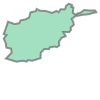

In [6]:
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
sorted_dataframe = gpu_dataframe.sort_values("NAME")
sorted_dataframe = sorted_dataframe.to_geopandas()
sorted_dataframe['geometry'].iloc[0]

## Trajectories (LineString)

In [7]:
# 1m random trajectory samples
ids = cupy.random.randint(1, 400, 1000000)
timestamps = cupy.random.random(1000000)*1000000
xy= cupy.random.random(2000000)
trajs = cuspatial.GeoSeries.from_points_xy(xy)
sorted_trajectories, trajectory_offsets = \
    cuspatial.core.trajectory.derive_trajectories(ids, trajs, timestamps)
# sorted_trajectories is a DataFrame containing all trajectory samples
# sorted first by `object_id` and then by `timestamp`.
print(sorted_trajectories.head())
# trajectory_offsets is a Series containing the start position of each
# trajectory in sorted_trajectories.
print(trajectory_offsets)

   object_id         x         y               timestamp
0          1  0.680146  0.874341 1970-01-01 00:00:00.125
1          1  0.843522  0.044402 1970-01-01 00:00:00.834
2          1  0.837039  0.351025 1970-01-01 00:00:01.335
3          1  0.946184  0.479038 1970-01-01 00:00:01.791
4          1  0.117322  0.182117 1970-01-01 00:00:02.474
0           0
1        2455
2        4899
3        7422
4        9924
        ...  
394    987408
395    989891
396    992428
397    994975
398    997448
Length: 399, dtype: int32


In [8]:
trajs = cuspatial.GeoSeries.from_points_xy(
    sorted_trajectories[["x", "y"]].interleave_columns()
)
d_and_s = cuspatial.core.trajectory.trajectory_distances_and_speeds(
  len(cudf.Series(ids).unique()),
  sorted_trajectories['object_id'],
  trajs,
  sorted_trajectories['timestamp']
)
print(d_and_s.head())

                   distance        speed
trajectory_id                           
0              1.278996e+06  1280.320089
1              1.267179e+06  1268.370390
2              1.294437e+06  1295.905261
3              1.323413e+06  1323.956714
4              1.309590e+06  1311.561012


## Bounding

* In cuSpatial, a function **cuspatial.trajectory_bounding_boxes**, computes bounding boxes for many trajectories at once on the GPU.
* Can be used for **spatial filtering**, **spatial indexing**, **trajectory joins** and **trajectory clustering**.
* Before doing expensive checks like if two trajectories collide, we can first check if their bounding boxes overlap, if they don’t, we can skip the expensive operations


In [9]:
bounding_boxes = cuspatial.core.trajectory.trajectory_bounding_boxes(
  len(cudf.Series(ids, dtype="int32").unique()),
  sorted_trajectories['object_id'],
  trajs
)
print(bounding_boxes.head())

      x_min     y_min     x_max     y_max
0  0.000098  0.000243  0.999422  0.999068
1  0.000663  0.000414  0.999813  0.998456
2  0.000049  0.000220  0.999748  0.999220
3  0.000006  0.000303  0.999729  0.999762
4  0.001190  0.000074  0.999299  0.999858


In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

/home/saketh/miniconda3/envs/cuspatial_env/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:335: UserWarning: GroupBy.groups() performance scales poorly with number of groups. Got 399 groups.
  warnings.warn(


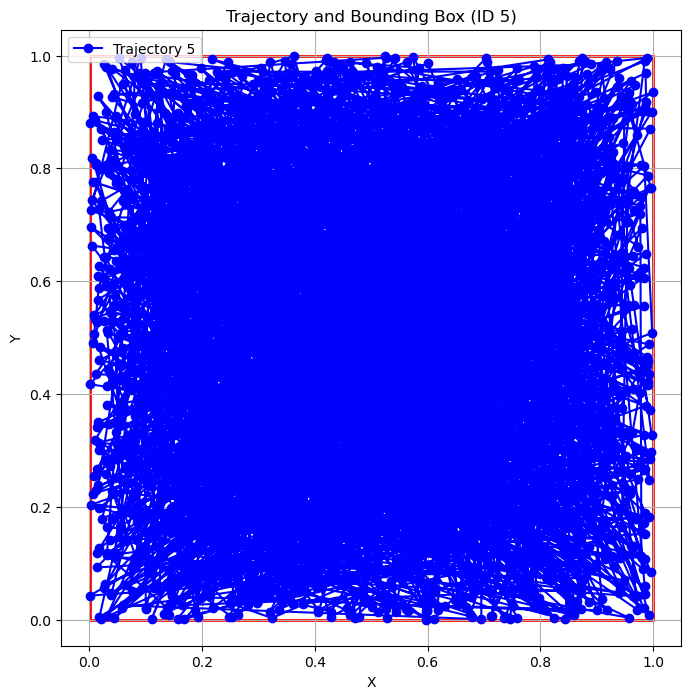

In [11]:
object_id_to_plot = 5

fig, ax = plt.subplots(figsize=(8, 8))

if object_id_to_plot < len(bounding_boxes):
    min_x = bounding_boxes.iloc[object_id_to_plot, 0]
    min_y = bounding_boxes.iloc[object_id_to_plot, 1]
    max_x = bounding_boxes.iloc[object_id_to_plot, 2]
    max_y = bounding_boxes.iloc[object_id_to_plot, 3]

    width = max_x - min_x
    height = max_y - min_y

    rect = patches.Rectangle((min_x, min_y), width, height, 
                              linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

grouped = sorted_trajectories.groupby('object_id')

if object_id_to_plot in grouped.groups:
    group = grouped.get_group(object_id_to_plot)
    
    x = group['x'].to_pandas()
    y = group['y'].to_pandas()
    
    ax.plot(x, y, marker='o', linestyle='-', label=f'Trajectory {object_id_to_plot}', color='blue')

ax.set_title(f'Trajectory and Bounding Box (ID {object_id_to_plot})')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid(True)
ax.axis('equal')
plt.show()

#### polygon_bounding_boxes supports more complex geometry objects like Polygons with multiple rings

In [12]:
single_polygons = cuspatial.from_geopandas(
    host_dataframe['geometry'][host_dataframe['geometry'].type == "Polygon"]
)
bounding_box_polygons = cuspatial.core.spatial.bounding.polygon_bounding_boxes(
    single_polygons
)
print(bounding_box_polygons.head())

        minx       miny       maxx       maxy
0  29.339998 -11.720938  40.316590  -0.950000
1 -17.063423  20.999752  -8.665124  27.656426
2  46.466446  40.662325  87.359970  55.385250
3  55.928917  37.144994  73.055417  45.586804
4  12.182337 -13.257227  31.174149   5.256088


In [13]:
lines = cuspatial.GeoSeries.from_linestrings_xy(
    trajs.points.xy, trajectory_offsets, cupy.arange(len(trajectory_offsets))
)
# we can treat trajectories as Linestrings and compute the same bounding boxes from the above trajectory calculation
trajectory_bounding_boxes = cuspatial.core.spatial.bounding.linestring_bounding_boxes(
    lines, 0.0001
)
print(trajectory_bounding_boxes.head())

       minx      miny      maxx      maxy
0 -0.000002  0.000143  0.999522  0.999168
1  0.000563  0.000314  0.999913  0.998556
2 -0.000051  0.000120  0.999848  0.999320
3 -0.000094  0.000203  0.999829  0.999862
4  0.001090 -0.000026  0.999399  0.999958


## Projection

In [14]:
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
germany = gpu_dataframe['geometry'][gpu_dataframe['NAME'] == 'Germany']
points = cuspatial.GeoSeries.from_points_xy(germany.polygons.xy)
projected = cuspatial.sinusoidal_projection(
    germany.polygons.x.mean(),
    germany.polygons.y.mean(),
    points
)
print(projected.head())

0    POINT (-232.432 -301.407)
1    POINT (-249.699 -244.867)
2    POINT (-231.381 -215.211)
3     POINT (-257.23 -175.609)
4    POINT (-275.844 -116.176)
dtype: geometry


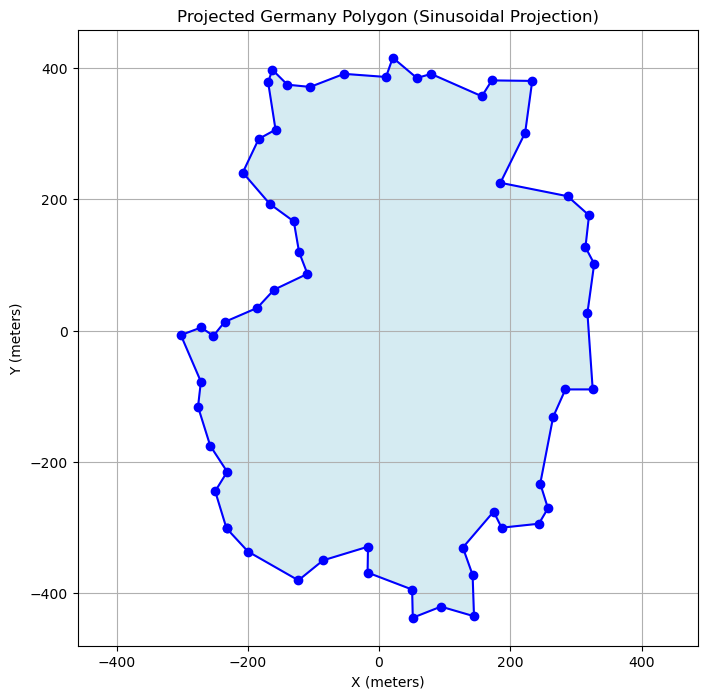

In [15]:
import matplotlib.pyplot as plt

# Extract x and y coordinates
x = projected.points.x.to_pandas()
y = projected.points.y.to_pandas()

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, y, linestyle='-', marker='o', color='blue')
ax.fill(x, y, color='lightblue', alpha=0.5)

ax.set_title('Projected Germany Polygon (Sinusoidal Projection)')
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.grid(True)
ax.axis('equal')
plt.show()


**Directed Hausdorff distance**
* Greatest of all the distances between any point in the first space to the closet point in the second.
* Useful as a similarity metric between trajectories.


In [16]:
coordinates = sorted_trajectories[['x', 'y']].interleave_columns()
spaces = cuspatial.GeoSeries.from_multipoints_xy(
    coordinates, trajectory_offsets
)
hausdorff_distances = cuspatial.core.spatial.distance.directed_hausdorff_distance(
    spaces
)
print(hausdorff_distances.head())

        0         1         2         3         4         5         6    \
0  0.000000  0.034755  0.031989  0.031959  0.031873  0.038674  0.029961   
1  0.030328  0.000000  0.038672  0.032086  0.031049  0.032170  0.032275   
2  0.027640  0.030539  0.000000  0.036737  0.033055  0.043447  0.028812   
3  0.031497  0.033380  0.035224  0.000000  0.032581  0.035484  0.030339   
4  0.031079  0.032256  0.035731  0.039084  0.000000  0.036416  0.031369   

        7         8         9    ...       388       389       390       391  \
0  0.029117  0.040962  0.033259  ...  0.031614  0.036447  0.035548  0.028233   
1  0.030215  0.034443  0.032998  ...  0.030594  0.035665  0.031473  0.031916   
2  0.031807  0.039269  0.033250  ...  0.031998  0.033636  0.034646  0.032615   
3  0.034792  0.045755  0.031810  ...  0.033623  0.031359  0.034923  0.032287   
4  0.030388  0.033751  0.034029  ...  0.030705  0.040339  0.034328  0.029027   

        392       393       394       395       396       397  
0  0

In [17]:
# 